In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.
## 1. Problem defition

    How well can we predict the future sale price of a bulldozer, given its characteristics and previous examples of how much similar bulldozers have been sold for?

## 2. Data

The data is downloaded from the Kaggle Bluebook for Bulldozers competition: https://www.kaggle.com/c/bluebook-for-bulldozers/data

There are 3 main datasets:

    Train.csv is the training set, which contains data through the end of 2011.
    Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
    Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.

## 3. Evaluation

The evaluation metric for this competition is the RMSLE (root mean squared log error) between the actual and predicted auction prices.

For more on the evaluation of this project check: https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation

Note: The goal for most regression evaluation metrics is to minimize the error. For example, our goal for this project will be to build a machine learning model which minimises RMSLE.
## 4. Features

Kaggle provides a data dictionary detailing all of the features of the dataset. You can view this data dictionary on Google Sheets: https://docs.google.com/spreadsheets/d/18ly-bLR8sbDJLITkWG7ozKm8l3RyieQ2Fpgix-beSYI/edit?usp=sharing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
data = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv" , low_memory=False)

The reason we get this low_memory warning is because guessing dtypes for each column is very memory demanding. Pandas tries to determine what dtype to set by analyzing the data in each column.

In [3]:
data.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
saledate                     object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                

In [4]:
data.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

In [5]:
data.saledate[:1000]

0      11/16/2006 0:00
1       3/26/2004 0:00
2       2/26/2004 0:00
3       5/19/2011 0:00
4       7/23/2009 0:00
            ...       
995     7/16/2009 0:00
996     6/14/2007 0:00
997     9/22/2005 0:00
998     7/28/2005 0:00
999     6/16/2011 0:00
Name: saledate, Length: 1000, dtype: object

## Parsing dates

When we work with time series data, we want to enrich the time & date component as much as possible.

We can do that by telling pandas which of our columns has dates in it using the parse_dates parameter.


In [6]:
df = pd.read_csv("data/bluebook-for-bulldozers/TrainAndValid.csv" , low_memory=False , parse_dates=["saledate"])

In [7]:
df.saledate.dtype

dtype('<M8[ns]')

In [8]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,2006-11-16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,2004-03-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2004-02-26,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,2011-05-19,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,2009-07-23,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



## Sort DataFrame by saledate

When working with time series data, it's a good idea to sort it by date.


In [9]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)

In [10]:
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,Straight,None or Unspecified,NaN,NaN
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,Lever,NaN,NaN


### Make a copy of the original DataFrame

In [11]:
df_tmp = df.copy()


Add datetime parameters for **saledate** column


In [12]:
df_tmp["saleYear"] = df_tmp.saledate.dt.year
df_tmp["saleMonth"] = df_tmp.saledate.dt.month
df_tmp["saleDay"] = df_tmp.saledate.dt.day
df_tmp["saleDayOfWeek"] = df_tmp.saledate.dt.dayofweek
df_tmp["saleDayOfYear"] = df_tmp.saledate.dt.dayofyear

In [13]:
df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
205615,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,1989-01-17,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
274835,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
141296,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,1989-01-31,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
212552,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,1989-01-31,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
62755,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,1989-01-31,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [14]:
df_tmp.drop(columns=["saledate"] , inplace=True)

In [15]:
len(df_tmp)

412698

# Modeling

In [16]:
df_tmp.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                 object
Blade_Extension             

In [17]:
df_tmp["UsageBand"].dtype

dtype('O')

In [18]:
df_tmp.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension             386715
Blade_Width         

# Convert string to categories

One way we can turn all of our data into numbers is by converting them into pandas catgories.

In [19]:
pd.api.types.is_string_dtype(df_tmp["UsageBand"])

False

In [20]:
# Find the columns which contain strings
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

fiModelDesc
fiBaseModel
fiProductClassDesc
state
ProductGroup
ProductGroupDesc


In [21]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

In [22]:
df_tmp.dtypes


SalesID                        int64
SalePrice                    float64
MachineID                      int64
ModelID                        int64
datasource                     int64
auctioneerID                 float64
YearMade                       int64
MachineHoursCurrentMeter     float64
UsageBand                   category
fiModelDesc                 category
fiBaseModel                 category
fiSecondaryDesc             category
fiModelSeries               category
fiModelDescriptor           category
ProductSize                 category
fiProductClassDesc          category
state                       category
ProductGroup                category
ProductGroupDesc            category
Drive_System                category
Enclosure                   category
Forks                       category
Pad_Type                    category
Ride_Control                category
Stick                       category
Transmission                category
Turbocharged                category
B

now have a way to access all of our data in the form of numbers.

But we still have a bunch of missing data...

# Save preprocessed data


In [23]:
# Export current tmp dataframe
df_tmp.to_csv("data/bluebook-for-bulldozers/train_tmp.csv",
              index=False)

In [24]:
# Import preprocessed data to file
df_tmp = pd.read_csv("data/bluebook-for-bulldozers/train_tmp.csv",
                     low_memory=False)

df_tmp.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear
0,1646770,9500.0,1126363,8434,132,18.0,1974,NaN,NaN,TD20,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,17,1,17
1,1821514,14000.0,1194089,10150,132,99.0,1980,NaN,NaN,A66,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
2,1505138,50000.0,1473654,4139,132,99.0,1978,NaN,NaN,D7G,...,None or Unspecified,Straight,None or Unspecified,NaN,NaN,1989,1,31,1,31
3,1671174,16000.0,1327630,8591,132,99.0,1980,NaN,NaN,A62,...,NaN,NaN,NaN,Standard,Conventional,1989,1,31,1,31
4,1329056,22000.0,1336053,4089,132,99.0,1984,NaN,NaN,D3B,...,None or Unspecified,PAT,Lever,NaN,NaN,1989,1,31,1,31


In [25]:
df_tmp.dtypes

SalesID                       int64
SalePrice                   float64
MachineID                     int64
ModelID                       int64
datasource                    int64
auctioneerID                float64
YearMade                      int64
MachineHoursCurrentMeter    float64
UsageBand                    object
fiModelDesc                  object
fiBaseModel                  object
fiSecondaryDesc              object
fiModelSeries                object
fiModelDescriptor            object
ProductSize                  object
fiProductClassDesc           object
state                        object
ProductGroup                 object
ProductGroupDesc             object
Drive_System                 object
Enclosure                    object
Forks                        object
Pad_Type                     object
Ride_Control                 object
Stick                        object
Transmission                 object
Turbocharged                 object
Blade_Extension             

all of the category datatype columns are back to the object datatype.

This happens because of the limitations of the CSV (.csv) file format, it doesn't preserve data types, rather it stores all the values as strings.

So when we read in a CSV, pandas defaults to interpreting strings as object datatypes.

In [26]:
# This will turn all of the string value into category values
for label, content in df_tmp.items():
    if pd.api.types.is_object_dtype(content):
        df_tmp[label] = content.astype("category").cat.as_ordered()

Now if we wanted to preserve the datatypes of our data, we can save to parquet or feather format.

In [27]:
# To save to parquet format requires pyarrow or fastparquet (or both)
# Can install via `pip install pyarrow fastparquet`
df_tmp.to_parquet(path="data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.parquet", 
                  engine="auto") # "auto" will automatically use pyarrow or fastparquet, defaulting to pyarrow first

In [28]:
# Read in df_tmp from parquet format
df_tmp = pd.read_parquet(path="data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories.parquet",
                         engine="auto")

# Using parquet format, datatypes are preserved
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor         748

## Finding and filling missing values

### numirical values

In [29]:
# finding numirical columns 
for label , content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear


In [30]:
# check the nul numirical values
for label , content in df_tmp.items():
        if pd.api.types.is_numeric_dtype(content):
            if content.isna().sum():
                print(label)

auctioneerID
MachineHoursCurrentMeter


### 2.6 Discussing possible ways to handle missing values

As previously discussed, there are many ways to fill missing values.

For missing numeric values, some potential options are:

| **Method** | **Pros**  | **Cons** |
|-----|-----|-----|
| **Fill with mean of column** | - Easy to calculate/implement <br> - Retains overall data distribution | - Averages out variation <br> - Affected by outliers (e.g. if one value is much higher/lower than others) |
| **Fill with median of column** | - Easy to calculate/implement <br> - Robust to outliers <br> - Preserves center of data  | - Ignores data distribution shape |
| **Fill with mode of column** | - Easy to calculate/implement <br> - More useful for categorical-like data | - May not make sense for continuous/numerical data  |
| **Fill with 0 (or another constant)** | - Simple to implement <br> - Useful in certain contexts like counts  | - Introduces bias (e.g. if 0 was a value that meant something) <br> - Skews data (e.g. if many missing values, replacing all with 0 makes it look like that's the most common value)  |
| **Forward/Backward fill (use previous/future values to fill future/previous values)**  | - Maintains temporal continuity (for time series) | - Assumes data is continuous, which may not be valid |
| **Use a calculation from other columns** | - Takes existing information and reinterprets it | - Can result in unlikely outputs if calculations are not continuous | 
| **Interpolate  (e.g. like dragging a cell in Excel/Google Sheets)** | - Captures trends <br> - Suitable for ordered data | - Can introduce errors <br> - May assume linearity (data continues in a straight line) |
| **Drop missing values** | - Ensures complete data (only use samples with all information) <br> - Useful for small datasets | - Can result in data loss (e.g. if many missing values are scattered across columns, data size can be dramatically reduced) <br> - Reduces dataset size  |

Which method you choose will be dataset and problem dependant and will likely require several phases of experimentation to see what works and what doesn't.

For now, we'll fill our missing numeric values with the median value of the target column.

We'll also add a binary column (0 or 1) with rows reflecting whether or not a value was missing.

For example, `MachineHoursCurrentMeter_is_missing` will be a column with rows which have a value of `0` if that row's `MachineHoursCurrentMeter` column was *not* missing and `1` if it was.



In [31]:
# Fill missing numeric values with the median of the target column
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            
            # Add a binary column which tells if the data was missing our not
            df_tmp[label+"_is_missing"] = pd.isnull(content).astype(int) # this will add a 0 or 1 value to rows with missing values (e.g. 0 = not missing, 1 = missing)

            # Fill missing numeric values with median since it's more robust than the mean
            df_tmp[label] = content.fillna(content.median())



Why add a binary column indicating whether the data was missing or not?

We can easily fill all of the missing numeric values in our dataset with the median.

However, a numeric value may be missing for a reason.

Adding a binary column which indicates whether the value was missing or not helps to retain this information. It also means we can inspect these rows later on.


In [32]:
# Check to see how many examples in the auctioneerID were missing
df_tmp.auctioneerID_is_missing.value_counts()

auctioneerID_is_missing
0    392562
1     20136
Name: count, dtype: int64

### Filling missing categorical values with pandas

In [33]:
# finding categorical columns 
for label , content in df_tmp.items():
    if pd.api.types.is_categorical_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [34]:
# check the nul categorical values
for label , content in df_tmp.items():
    if pd.api.types.is_categorical_dtype(content):
            if content.isna().sum():
                print(label)

UsageBand
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [35]:
# 1. Create a dictionary to store column to category values (e.g. we turn our category types into numbers but we keep a record so we can go back)
column_to_category_dict = {} 

# 2. Turn categorical variables into numbers
for label, content in df_tmp.items():

    # 3. Check columns which *aren't* numeric
    if not pd.api.types.is_numeric_dtype(content):

        # 4. Add binary column to inidicate whether sample had missing value
        df_tmp[label+"_is_missing"] = pd.isnull(content).astype(int)

        # 5. Ensure content is categorical and get its category codes
        content_categories = pd.Categorical(content)
        content_category_codes = content_categories.codes + 1 # prevents -1 (the default for NaN values) from being used for missing values (we'll treat missing values as 0)

        # 6. Add column key to dictionary with code: category mapping per column
        column_to_category_dict[label] = dict(zip(content_category_codes, content_categories))
        
        # 7. Set the column to the numerical values (the category code value) 
        df_tmp[label] = content_category_codes  

In [36]:
df_tmp.isna().sum()

SalesID                         0
SalePrice                       0
MachineID                       0
ModelID                         0
datasource                      0
                               ..
Backhoe_Mounting_is_missing     0
Blade_Type_is_missing           0
Travel_Controls_is_missing      0
Differential_Type_is_missing    0
Steering_Controls_is_missing    0
Length: 103, dtype: int64

In [37]:
# Check the UsageBand (measure of bulldozer usage)
for key, value in sorted(column_to_category_dict["UsageBand"].items()): # note: calling sorted() on dictionary.items() sorts the dictionary by keys 
    print(f"{key} -> {value}")

0 -> nan
1 -> High
2 -> Low
3 -> Medium


### Saving our preprocessed data (part 2)

In [38]:
df_tmp.to_parquet(path="data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories_and_missing_values_filled.parquet",
                  engine="auto")

### Fitting a machine learning model to our preprocessed data

In [71]:
# Read in preprocessed dataset
df_tmp = pd.read_parquet(path="data/bluebook-for-bulldozers/TrainAndValid_object_values_as_categories_and_missing_values_filled.parquet",
                         engine="auto")

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
# Import train samples (making sure to parse dates and then sort by them)
train_df = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/Train.csv",
                       parse_dates=["saledate"],
                       low_memory=False).sort_values(by="saledate", ascending=True)

# Import validation samples (making sure to parse dates and then sort by them)
valid_df = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/Valid.csv",
                       parse_dates=["saledate"])

# The ValidSolution.csv contains the SalePrice values for the samples in Valid.csv
valid_solution = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/ValidSolution.csv")

# Map valid_solution to valid_df
valid_df["SalePrice"] = valid_df["SalesID"].map(valid_solution.set_index("SalesID")["SalePrice"])

# Make sure valid_df is sorted by saledate still
valid_df = valid_df.sort_values("saledate", ascending=True).reset_index(drop=True)

# How many samples are in each DataFrame?
print(f"[INFO] Number of samples in training DataFrame: {len(train_df)}")
print(f"[INFO] Number of samples in validation DataFrame: {len(valid_df)}")

[INFO] Number of samples in training DataFrame: 401125
[INFO] Number of samples in validation DataFrame: 11573


In [74]:
# Make a function to add date columns
def add_datetime_features_to_df(df, date_column="saledate"):
    # Add datetime parameters for saledate
    df["saleYear"] = df[date_column].dt.year
    df["saleMonth"] = df[date_column].dt.month
    df["saleDay"] = df[date_column].dt.day
    df["saleDayofweek"] = df[date_column].dt.dayofweek
    df["saleDayofyear"] = df[date_column].dt.dayofyear

    # Drop original saledate column
    df.drop("saledate", axis=1, inplace=True)

    return df

train_df = add_datetime_features_to_df(df=train_df)
valid_df = add_datetime_features_to_df(df=valid_df)

In [75]:
# Split training data into features and labels
X_train = train_df.drop("SalePrice", axis=1)
y_train = train_df["SalePrice"]

# Split validation data into features and labels
X_valid = valid_df.drop("SalePrice", axis=1)
y_valid = valid_df["SalePrice"]

# Create a model
model = RandomForestRegressor(n_jobs=-1)

# Fit a model to the training data only
model.fit(X=X_train,
          y=y_train)

ValueError: could not convert string to float: 'Medium'

In [76]:
# Define numerical and categorical features
numerical_features = [label for label, content in X_train.items() if pd.api.types.is_numeric_dtype(content)]
categorical_features = [label for label, content in X_train.items() if not pd.api.types.is_numeric_dtype(content)]

In [78]:
from sklearn.preprocessing import OrdinalEncoder

# 1. Create an ordinal encoder (turns category items into numeric representation)
ordinal_encoder = OrdinalEncoder(categories="auto",
                                 handle_unknown="use_encoded_value",
                                 unknown_value=np.nan,
                                 encoded_missing_value=np.nan) # treat unknown categories as np.nan (or None)

# 2. Fit and transform the categorical columns of X_train
X_train_preprocessed = X_train.copy() # make copies of the oringal DataFrames so we can keep the original values in tact and view them later
X_train_preprocessed[categorical_features] = ordinal_encoder.fit_transform(X_train_preprocessed[categorical_features].astype(str)) # OrdinalEncoder expects all values as the same type (e.g. string or numeric only)

# 3. Transform the categorical columns of X_valid 
X_valid_preprocessed = X_valid.copy()
X_valid_preprocessed[categorical_features] = ordinal_encoder.transform(X_valid_preprocessed[categorical_features].astype(str)) # only use `transform` on the validation data



In [90]:
# Fill missing numeric values with the median of the target column
for label, content in X_train_preprocessed.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            
            # Fill missing numeric values with median since it's more robust than the mean
            X_train_preprocessed[label] = content.fillna(content.median())

for label, content in X_valid_preprocessed.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            
            # Fill missing numeric values with median since it's more robust than the mean
            X_valid_preprocessed[label] = content.fillna(content.median())

In [85]:
X_train_preprocessed[numerical_features].isna().sum().sort_values(ascending=False)

SalesID                     0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
saleYear                    0
saleMonth                   0
saleDay                     0
dtype: int64

In [86]:
X_train_preprocessed[categorical_features].isna().sum().sort_values(ascending=False)

UsageBand                  0
fiModelDesc                0
Pushblock                  0
Ripper                     0
Scarifier                  0
Tip_Control                0
Tire_Size                  0
Coupler                    0
Coupler_System             0
Grouser_Tracks             0
Hydraulics_Flow            0
Track_Type                 0
Undercarriage_Pad_Width    0
Stick_Length               0
Thumb                      0
Pattern_Changer            0
Grouser_Type               0
Backhoe_Mounting           0
Blade_Type                 0
Travel_Controls            0
Differential_Type          0
Hydraulics                 0
Engine_Horsepower          0
Enclosure_Type             0
ProductGroupDesc           0
fiBaseModel                0
fiSecondaryDesc            0
fiModelSeries              0
fiModelDescriptor          0
ProductSize                0
fiProductClassDesc         0
state                      0
ProductGroup               0
Drive_System               0
Blade_Width   

In [87]:
# Create a dictionary of dictionaries mapping column names and their variables to their numerical encoding
column_to_category_mapping = {}

for column_name, category_values in zip(categorical_features, ordinal_encoder.categories_):
    int_to_category = {i: category for i, category in enumerate(category_values)}
    column_to_category_mapping[column_name] = int_to_category

# Inspect an example column name to category mapping
column_to_category_mapping["UsageBand"]

{0: 'High', 1: 'Low', 2: 'Medium', 3: 'nan'}

### Fitting a model to our preprocessed training data

In [88]:
%%time

# Instantiate a Random Forest Regression model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model to the preprocessed training data
model.fit(X=X_train_preprocessed,
          y=y_train)

CPU times: total: 35min 3s
Wall time: 5min 2s


RandomForestRegressor(n_jobs=-1)

In [91]:
%%time

# Check model performance on the validation set
model.score(X=X_valid_preprocessed,
            y=y_valid)

CPU times: total: 281 ms
Wall time: 142 ms


0.869983688873244

## Building an evaluation function

Evaluating a machine learning model is just as important as training one.

And so because of this, let's create an evaluation function to make evaluation faster and reproducible.

According to Kaggle for the Bluebook for Bulldozers competition, [the evaluation function](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation) they use is root mean squared log error (RMSLE).

$$ \text{RMSLE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left( \log(1 + \hat{y}_i) - \log(1 + y_i) \right)^2} $$

Where:

* $ \hat{y}_i $ is the predicted value,  
* $ y_i $ is the actual value,  
* $ n $ is the number of observations.

Contrast this with mean absolute error (MAE), another common regression metric.

$$ \text{MAE} = \frac{1}{n} \sum_{i=1}^{n} \left| \hat{y}_i - y_i \right| $$

With RMSLE, the relative error is more meaningful than the absolute error. You care more about ratios than absolute errors. For example, being off by $100 on a $1000 prediction (10% error) is more significant than being off by $100 on a $10,000 prediction (1% error). RMSLE is sensitive to large percentage errors.

Where as with MAE, is more about exact differences, a $100 prediction error is weighted the same regardless of the actual value.

In each of case, a lower value (closer to 0) is better.

For any problem, it's important to define the evaluation metric you're going to try and improve on.

In our case, let's create a function that calculates multiple evaluation metrics.

Namely, we'll use:

* MAE (mean absolute error) via [`sklearn.metrics.mean_absolute_error`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.mean_absolute_error.html) - lower is better.
* RMSLE (root mean squared log error) via [`sklearn.metrics.root_mean_squared_log_error`](https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.root_mean_squared_log_error.html) - lower is better.
* $R^2$ (R-squared or coefficient of determination) via the [`score` method](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.score) - higher is better.

For MAE and RMSLE we'll be comparing the model's predictions to the truth labels.

We can get an array of predicted values from our model using [`model.predict(X=features_to_predict_on)`](https://scikit-learn.org/dev/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.predict). 

In [94]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error
import numpy as np  # For calculating square root

# Create function to evaluate our model
def show_scores(model, 
                train_features=X_train_preprocessed,
                train_labels=y_train,
                valid_features=X_valid_preprocessed,
                valid_labels=y_valid):
    
    # Make predictions on train and validation features
    train_preds = model.predict(X=train_features)
    val_preds = model.predict(X=valid_features)

    # Create a scores dictionary of different evaluation metrics
    scores = {
       
        "Valid MAE": mean_absolute_error(y_true=valid_labels, 
                                         y_pred=val_preds),
        
        # Calculate RMSLE manually
        "Valid RMSLE": np.sqrt(mean_squared_log_error(y_true=valid_labels, 
                                                      y_pred=val_preds)),
        
        "Valid R^2": model.score(X=valid_features, 
                                 y=valid_labels)
    }
    return scores


In [95]:
# Try our model scoring function out
model_scores = show_scores(model=model)
model_scores

{'Valid MAE': 6178.2513911691,
 'Valid RMSLE': 0.2566509679964195,
 'Valid R^2': 0.869983688873244}


## Tuning our model's hyperparameters

Hyperparameters are the settings we can change on our model.

And tuning hyperparameters on a given model can often alter its performance on a given dataset.

Ideally, changing hyperparameters would lead to better results.

However, it's often hard to know what hyperparameter changes would improve a model ahead of time.

So what we can do is run several experiments across various different hyperparameter settings and record which lead to the best results.


Making our modelling experiments faster (to speed up hyperparameter tuning)

Because of the size of our dataset (~400,000 rows), retraining an entire model for each new set of hyperparameters would take far too long to continuing experimenting as fast as we want to.

In [97]:
%%time

# Change max samples in RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, # this is the default
                              n_jobs=-1,
                              max_samples=10000) # each estimator sees max_samples (the default is to see all available samples)

# Cutting down the max number of samples each tree can see improves training time
model.fit(X_train_preprocessed, 
          y_train)

CPU times: total: 2min 34s
Wall time: 24 s


RandomForestRegressor(max_samples=10000, n_jobs=-1)

In [98]:
# Get evaluation metrics from reduced sample model
base_model_scores = show_scores(model=model)
base_model_scores

{'Valid MAE': 7199.446458999396,
 'Valid RMSLE': 0.2944010417303538,
 'Valid R^2': 0.8301678150678731}

### Hyperparameter tuning with RandomizedSearchCV

In [99]:
%%time

from sklearn.model_selection import RandomizedSearchCV

# 1. Define a dictionary with different values for RandomForestRegressor hyperparameters
# See documatation for potential different values - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html 
rf_grid = {"n_estimators": np.arange(10, 200, 10),
           "max_depth": [None, 10, 20],
           "min_samples_split": np.arange(2, 10, 1), # min_samples_split must be an int in the range [2, inf) or a float in the range (0.0, 1.0]
           "min_samples_leaf": np.arange(1, 10, 1),
           "max_features": [0.5, 1.0, "sqrt"], # Note: "max_features='auto'" is equivalent to "max_features=1.0", as of Scikit-Learn version 1.1
           "max_samples": [10000]}

# 2. Setup instance of RandomizedSearchCV to explore different parameters 
rs_model = RandomizedSearchCV(estimator=RandomForestRegressor(), # can pass new model instance directly, all settings will be taken from the rf_grid
                              param_distributions=rf_grid,
                              n_iter=20,
                            #   scoring="neg_root_mean_squared_log_error", # want to optimize for RMSLE, though sometimes optimizing for the default metric (R^2) can lead to just as good results all round
                              cv=3,
                              verbose=3) # control how much output gets produced, higher number = more output

# 3. Fit the model using a series of different hyperparameter values
rs_model.fit(X=X_train_preprocessed, 
             y=y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV 1/3] END max_depth=20, max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=3, n_estimators=90;, score=0.547 total time=  44.2s
[CV 2/3] END max_depth=20, max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=3, n_estimators=90;, score=0.761 total time=  41.3s
[CV 3/3] END max_depth=20, max_features=0.5, max_samples=10000, min_samples_leaf=3, min_samples_split=3, n_estimators=90;, score=0.638 total time=  40.9s
[CV 1/3] END max_depth=10, max_features=1.0, max_samples=10000, min_samples_leaf=2, min_samples_split=9, n_estimators=70;, score=0.538 total time=  38.0s
[CV 2/3] END max_depth=10, max_features=1.0, max_samples=10000, min_samples_leaf=2, min_samples_split=9, n_estimators=70;, score=0.716 total time=  37.3s
[CV 3/3] END max_depth=10, max_features=1.0, max_samples=10000, min_samples_leaf=2, min_samples_split=9, n_estimators=70;, score=0.598 total time=  36.1s
[CV 1/3] END ma

[CV 3/3] END max_depth=20, max_features=sqrt, max_samples=10000, min_samples_leaf=2, min_samples_split=8, n_estimators=130;, score=0.646 total time=   8.5s
[CV 1/3] END max_depth=20, max_features=1.0, max_samples=10000, min_samples_leaf=3, min_samples_split=9, n_estimators=50;, score=0.538 total time=  15.6s
[CV 2/3] END max_depth=20, max_features=1.0, max_samples=10000, min_samples_leaf=3, min_samples_split=9, n_estimators=50;, score=0.754 total time=  15.5s
[CV 3/3] END max_depth=20, max_features=1.0, max_samples=10000, min_samples_leaf=3, min_samples_split=9, n_estimators=50;, score=0.614 total time=  14.4s
[CV 1/3] END max_depth=10, max_features=sqrt, max_samples=10000, min_samples_leaf=8, min_samples_split=3, n_estimators=150;, score=0.487 total time=   6.1s
[CV 2/3] END max_depth=10, max_features=sqrt, max_samples=10000, min_samples_leaf=8, min_samples_split=3, n_estimators=150;, score=0.656 total time=   6.2s
[CV 3/3] END max_depth=10, max_features=sqrt, max_samples=10000, min_s

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': [0.5, 1.0, 'sqrt'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': array([2, 3, 4, 5, 6, 7, 8, 9]),
                                        'n_estimators': array([ 10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120, 130,
       140, 150, 160, 170, 180, 190])},
                   verbose=3)

In [100]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 3,
 'min_samples_leaf': 3,
 'max_samples': 10000,
 'max_features': 0.5,
 'max_depth': 20}

In [101]:
# Evaluate the RandomizedSearch model
rs_model_scores = show_scores(rs_model)
rs_model_scores

{'Valid MAE': 7303.58741280802,
 'Valid RMSLE': 0.29879064722463655,
 'Valid R^2': 0.8251520694754413}

### Training a model with the best hyperparameters

In [106]:
%%time

# Create a model with best found hyperparameters 
ideal_model = RandomForestRegressor(n_estimators=90,
                                    max_depth=None,
                                    min_samples_leaf=1,
                                    min_samples_split=5,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)


# Fit a model to the preprocessed data
ideal_model.fit(X=X_train_preprocessed, 
                y=y_train)

CPU times: total: 13min 5s
Wall time: 1min 56s


RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=90,
                      n_jobs=-1)

In [108]:
%%time

# Evaluate ideal model
ideal_model_scores = show_scores(model=ideal_model)
ideal_model_scores

CPU times: total: 18.7 s
Wall time: 2.92 s


{'Valid MAE': 5963.470218258221,
 'Valid RMSLE': 0.2476284086774502,
 'Valid R^2': 0.8814007569225321}

### Saving the model

In [110]:
import joblib

bulldozer_price_prediction_model_name = "randomforest_regressor_best_RMSLE.pkl"

# Save model to file
joblib.dump(value=ideal_model, 
            filename=bulldozer_price_prediction_model_name)

['randomforest_regressor_best_RMSLE.pkl']

In [111]:
# Load the best model
best_model = joblib.load(filename=bulldozer_price_prediction_model_name)
best_model

RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=90,
                      n_jobs=-1)

### Making predictions on test data

In [113]:
# Load the test data
test_df = pd.read_csv(filepath_or_buffer="data/bluebook-for-bulldozers/Test.csv",
                      parse_dates=["saledate"])
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,fiModelDesc,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1227829,1006309,3168,121,3,1999,3688.0,Low,2012-05-03,580G,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1227844,1022817,7271,121,3,1000,28555.0,High,2012-05-10,936,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,2012-05-10,EC210BLC,...,None or Unspecified,"9' 6""",Manual,None or Unspecified,Double,NaN,NaN,NaN,NaN,NaN
3,1227848,56204,1269,121,3,2006,8940.0,High,2012-05-10,330CL,...,None or Unspecified,None or Unspecified,Manual,Yes,Triple,NaN,NaN,NaN,NaN,NaN
4,1227863,1053887,22312,121,3,2005,2286.0,Low,2012-05-10,650K,...,NaN,NaN,NaN,NaN,NaN,None or Unspecified,PAT,None or Unspecified,NaN,NaN


In [114]:
# Make a function to add date columns
def add_datetime_features_to_df(df, date_column="saledate"):
    # Add datetime parameters for saledate
    df["saleYear"] = df[date_column].dt.year
    df["saleMonth"] = df[date_column].dt.month
    df["saleDay"] = df[date_column].dt.day
    df["saleDayofweek"] = df[date_column].dt.dayofweek
    df["saleDayofyear"] = df[date_column].dt.dayofyear

    # Drop original saledate column
    df.drop("saledate", axis=1, inplace=True)

    return df

# Preprocess test_df to have same columns as train_df (add the datetime features)
test_df = add_datetime_features_to_df(df=test_df)
test_df.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayofweek,saleDayofyear
0,1227829,1006309,3168,121,3,1999,3688.0,Low,580G,580,...,NaN,NaN,NaN,NaN,NaN,2012,5,3,3,124
1,1227844,1022817,7271,121,3,1000,28555.0,High,936,936,...,NaN,NaN,NaN,Standard,Conventional,2012,5,10,3,131
2,1227847,1031560,22805,121,3,2004,6038.0,Medium,EC210BLC,EC210,...,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
3,1227848,56204,1269,121,3,2006,8940.0,High,330CL,330,...,NaN,NaN,NaN,NaN,NaN,2012,5,10,3,131
4,1227863,1053887,22312,121,3,2005,2286.0,Low,650K,650,...,None or Unspecified,PAT,None or Unspecified,NaN,NaN,2012,5,10,3,131


In [118]:
# Create a copy of the test DataFrame to keep the original intact
test_df_preprocessed = test_df.copy()

# Transform the categorical features of the test DataFrame into numbers
test_df_preprocessed[categorical_features] = ordinal_encoder.transform(test_df_preprocessed[categorical_features].astype(str))
test_df_preprocessed.info()

for label, content in test_df_preprocessed.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            
            # Fill missing numeric values with median since it's more robust than the mean
            test_df_preprocessed[label] = content.fillna(content.median())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 56 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  2129 non-null   float64
 7   UsageBand                 12457 non-null  float64
 8   fiModelDesc               12349 non-null  float64
 9   fiBaseModel               12431 non-null  float64
 10  fiSecondaryDesc           12449 non-null  float64
 11  fiModelSeries             12456 non-null  float64
 12  fiModelDescriptor         12452 non-null  float64
 13  ProductSize               12457 non-null  float64
 14  fiProd

In [119]:
# Make predictions on the preprocessed test data
test_preds = best_model.predict(test_df_preprocessed)


In [121]:
#  Format predictions into the same format Kaggle is after
df_preds = pd.DataFrame()
df_preds["SalesID"] = test_df_preprocessed["SalesID"]
df_preds["SalesPrice"] = test_preds
df_preds

,SalesID,SalesPrice
0,1227829,15050.260141
1,1227844,32572.680375
2,1227847,49829.133598
3,1227848,97419.623016
4,1227863,26738.229718
...,...,...
12452,6643171,43347.043651
12453,6643173,10462.711640
12454,6643184,11684.060245
12455,6643186,14227.390452


### Feature Importance

In [122]:
ideal_model.feature_importances_

array([3.86595877e-02, 2.43496227e-02, 5.80188391e-02, 2.27746354e-03,
       4.63330193e-03, 1.98378977e-01, 4.03989229e-03, 1.50980509e-03,
       4.52330326e-02, 4.92098262e-02, 3.61559091e-02, 4.00993473e-03,
       2.63700459e-02, 1.59097070e-01, 4.86656077e-02, 8.40590819e-03,
       3.31212786e-03, 5.02673072e-03, 1.39667079e-03, 6.62928821e-02,
       1.05578085e-03, 1.32848423e-03, 2.85570472e-03, 7.80934366e-04,
       1.47236149e-03, 7.66094664e-05, 4.19688308e-03, 4.03583590e-03,
       4.04008689e-03, 2.69678214e-03, 4.30265448e-03, 2.57281454e-03,
       4.63220288e-03, 3.27825242e-03, 3.82921270e-03, 1.09302641e-02,
       1.99078531e-03, 2.23340018e-02, 9.24015848e-03, 8.85654695e-03,
       2.29719185e-03, 1.47097314e-03, 1.87982251e-03, 1.04642130e-03,
       6.44772929e-04, 7.20834228e-04, 6.06289450e-04, 2.36105134e-03,
       4.14209277e-03, 3.85760145e-04, 4.02592207e-04, 7.30466784e-02,
       5.47996465e-03, 8.64094420e-03, 4.50290263e-03, 1.28221160e-02])

In [123]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importances": importances})
          .sort_values("feature_importances", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    fig, ax = plt.subplots()
    ax.barh(df["features"][:n], df["feature_importances"][:20])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature importance")
    ax.invert_yaxis()

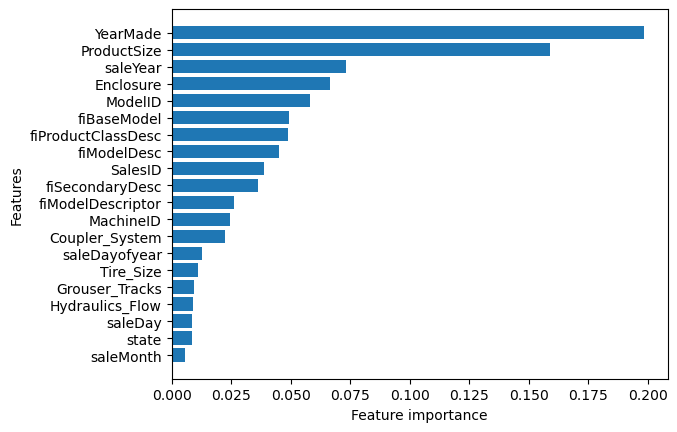

In [125]:
plot_features(test_df_preprocessed.columns, ideal_model.feature_importances_)